In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import optax
from functools import partial
from typing import Callable

from history import History

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from cmap import Colormap
cmap = Colormap('crameri:batlow').to_mpl()

In [2]:
from problems import Burgers
problem = Burgers()

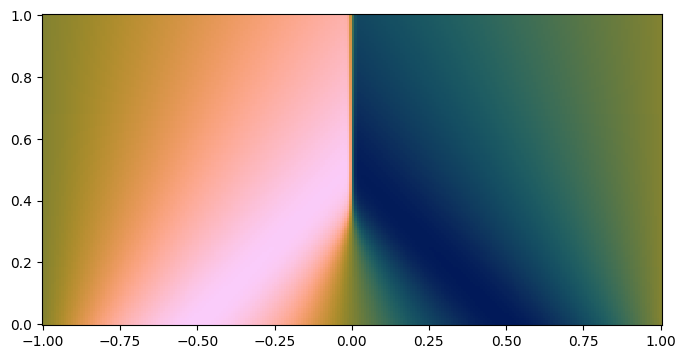

In [3]:
X, T, u_solution = problem.exact_solution(nx=256, nt=128)

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")
ax_exact = ax.pcolormesh(X, T, u_solution, cmap=cmap)

# Optimiser

In [4]:
class AggressiveLevenbergMarquardt:
    """
    Aggressive Levenberg-Marquardt optimiser.
    """

    def __init__(
        self,
        init_lambda=1e-3,
        decrease_factor: float = 1.5,
        increase_factor: float = 1.5,
        max_trials: int = 200,
    ):
        self.init_lambda = init_lambda
        self.decrease_factor = decrease_factor
        self.increase_factor = increase_factor
        self.max_trials = max_trials

    def init(self, params: eqx.Module):
        """Initializes the optimizer state with the initial damping factor."""
        return {'lambda': self.init_lambda}

    def update(
        self,
        params: eqx.Module,
        state: optax.OptState,
        residual_fn: Callable[[eqx.Module], jax.Array]
    ):
        current_lambda = state['lambda']
        params_flat, unflatten = jax.flatten_util.ravel_pytree(params)

        def flat_residual_fn(p_flat):
            return residual_fn(unflatten(p_flat))

        residuals = residual_fn(params)
        current_loss = jnp.mean(residuals**2)

        J = jax.jacfwd(flat_residual_fn)(params_flat)
        U, S, Vt = jnp.linalg.svd(J, full_matrices=False)

        def evaluate_trial_step(loop_val):
            trial_lambda, _, trial_count = loop_val
            
            delta = -Vt.T @ jnp.diag(S / (S**2 + trial_lambda)) @ U.T @ residuals

            trial_params = eqx.apply_updates(params, unflatten(delta))
            trial_residuals = residual_fn(trial_params)
            trial_loss = jnp.mean(trial_residuals**2)
            
            accepted = trial_loss < current_loss
            
            new_lambda = jax.lax.cond(
                accepted,
                lambda: trial_lambda / self.decrease_factor,
                lambda: trial_lambda * self.increase_factor
            )
            
            return new_lambda, accepted, trial_count + 1

        def continue_until_accepted(loop_val):
            # Continue if step is not accepted AND we haven't exceeded max trials
            _, accepted, trial_count = loop_val
            return jnp.logical_and(jnp.logical_not(accepted), trial_count < self.max_trials)

        # --- Run the loop to find an acceptable step and lambda ---
        final_lambda, step_was_accepted, _ = jax.lax.while_loop(
            continue_until_accepted, evaluate_trial_step, (current_lambda, False, 0)
        )

        final_delta = -Vt.T @ jnp.diag(S / (S**2 + final_lambda)) @ U.T @ residuals
        
        updates = unflatten(final_delta)
        new_state = {'lambda': final_lambda}

        metrics = { 
            'loss': current_loss,
            'singular_values': S,
            'search_direction_norm': jnp.linalg.norm(final_delta),
            'lambda': final_lambda,
        }

        return current_loss, updates, new_state, metrics


class StandardLevenbergMarquardt:
    """
    Standard Levenberg-Marquardt optimiser.
    """

    def __init__(
        self,
        init_lambda=1e-3,
        decrease_factor: float = 10,
        increase_factor: float = 2,
        max_trials: int = 200,
    ):
        self.init_lambda = init_lambda
        self.decrease_factor = decrease_factor
        self.increase_factor = increase_factor
        self.max_trials = max_trials

    def init(self, params: eqx.Module):
        """Initializes the optimizer state with the initial damping factor."""
        return {'lambda': self.init_lambda}

    def update(
        self,
        params: eqx.Module,
        state: optax.OptState,
        residual_fn: Callable[[eqx.Module], jax.Array]
    ):
        current_lambda = state['lambda']
        params_flat, unflatten = jax.flatten_util.ravel_pytree(params)

        def flat_residual_fn(p_flat):
            return residual_fn(unflatten(p_flat))

        residuals = residual_fn(params)
        current_loss = jnp.mean(residuals**2)

        J = jax.jacfwd(flat_residual_fn)(params_flat)
        U, S, Vt = jnp.linalg.svd(J, full_matrices=False)

        def evaluate_trial_step(loop_val):
            trial_lambda, _, trial_count = loop_val
            
            delta = -Vt.T @ jnp.diag(S / (S**2 + trial_lambda)) @ U.T @ residuals

            trial_params = eqx.apply_updates(params, unflatten(delta))
            trial_residuals = residual_fn(trial_params)
            trial_loss = jnp.mean(trial_residuals**2)
            
            accepted = trial_loss < current_loss
            
            new_lambda = jax.lax.cond(
                accepted,
                lambda: trial_lambda / self.decrease_factor,
                lambda: trial_lambda * self.increase_factor
            )
            
            return new_lambda, accepted, trial_count + 1

        def continue_until_accepted(loop_val):
            # Continue if step is not accepted AND we haven't exceeded max trials
            _, accepted, trial_count = loop_val
            return jnp.logical_and(jnp.logical_not(accepted), trial_count < self.max_trials)

        # --- Run the loop to find an acceptable step and lambda ---
        final_lambda, step_was_accepted, _ = jax.lax.while_loop(
            continue_until_accepted, evaluate_trial_step, (current_lambda, False, 0)
        )

        final_delta = -Vt.T @ jnp.diag(S / (S**2 + (final_lambda * self.decrease_factor))) @ U.T @ residuals
        
        updates = unflatten(final_delta)
        new_state = {'lambda': final_lambda}

        metrics = { 
            'loss': current_loss,
            'singular_values': S,
            'search_direction_norm': jnp.linalg.norm(final_delta),
            'lambda': final_lambda,
        }

        return current_loss, updates, new_state, metrics


@partial(jax.jit, static_argnums=(3, 4))
def train_step(params, static_parts, opt_state, optimiser, problem, collocation_points):
    def residual_fn_for_optimizer(p):
        rebuilt_model = eqx.combine(p, static_parts)
        return problem.physics_residual(problem.residual_fn, rebuilt_model, collocation_points, problem.nu)

    loss, updates, new_opt_state, metrics = optimiser.update(params, opt_state, residual_fn_for_optimizer)
    new_params = eqx.apply_updates(params, updates)
    
    return new_params, new_opt_state, loss, metrics

In [6]:
key = jax.random.PRNGKey(42)

# --- Hyperparameters ---
n_collocation_points = 2**13
layer_sizes = [2, 12, 12, 12, 12, 12, 1]
# -----------------------

model_key, data_key = jax.random.split(key)
model = problem.FCN(model_key, layer_sizes)
params, static = eqx.partition(model, eqx.is_array)

history = History()

optimiser1 = AggressiveLevenbergMarquardt(
)
opt_state = optimiser1.init(params)
collocation_points = problem.get_collocation_points(n_collocation_points, seed=1)

print(f"Starting PINN training with {type(optimiser1).__name__}...")
for epoch in range(400):
    params, opt_state, loss_val, metrics = train_step(
        params, static, opt_state, optimiser1, problem, collocation_points
    )
    history.record(metrics)
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss_val.item():.3e}")

model = eqx.combine(params, static)

optimiser2 = StandardLevenbergMarquardt(
)
opt_state = optimiser2.init(params)

print(f"Starting PINN training with {type(optimiser2).__name__}...")
for epoch in range(200):
    params, opt_state, loss_val, metrics = train_step(
        params, static, opt_state, optimiser2, problem, collocation_points
    )
    history.record(metrics)
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss_val.item():.3e}")

model = eqx.combine(params, static)
print("Training complete.")

Starting PINN training with AggressiveLevenbergMarquardt...


Epoch 20, Loss: 2.476e-01
Epoch 40, Loss: 6.048e-03
Epoch 60, Loss: 5.992e-04
Epoch 80, Loss: 5.520e-03
Epoch 100, Loss: 5.084e-05
Epoch 120, Loss: 7.249e-04
Epoch 140, Loss: 1.237e-05
Epoch 160, Loss: 6.239e-06
Epoch 180, Loss: 5.174e-05
Epoch 200, Loss: 5.877e-10
Epoch 220, Loss: 9.033e-11
Epoch 240, Loss: 1.265e-10
Epoch 260, Loss: 8.417e-11
Epoch 280, Loss: 7.700e-11
Epoch 300, Loss: 5.528e-11
Epoch 320, Loss: 5.500e-11
Epoch 340, Loss: 5.500e-11
Epoch 360, Loss: 5.500e-11
Epoch 380, Loss: 5.500e-11
Epoch 400, Loss: 5.500e-11
Starting PINN training with StandardLevenbergMarquardt...
Epoch 20, Loss: 4.664e-11
Epoch 40, Loss: 4.664e-11
Epoch 60, Loss: 4.664e-11
Epoch 80, Loss: 4.664e-11
Epoch 100, Loss: 4.664e-11
Epoch 120, Loss: 4.664e-11
Epoch 140, Loss: 4.664e-11
Epoch 160, Loss: 4.664e-11
Epoch 180, Loss: 4.664e-11
Epoch 200, Loss: 4.664e-11
Training complete.


Relative L2 Error: 6.858e-06


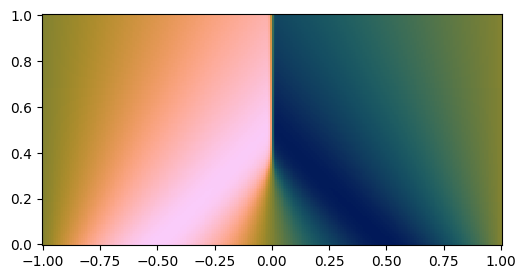

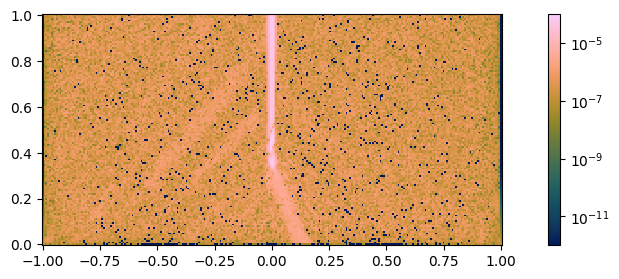

In [7]:
u_pred = model.predict(X, T)

error = jnp.abs(u_solution - u_pred)
rel_l2_error = jnp.linalg.norm(error) / jnp.linalg.norm(u_solution)

print(f"Relative L2 Error: {rel_l2_error:.3e}")

fig, ax = plt.subplots(figsize=(8, 3))
ax.set_aspect("equal")
nn_solution = ax.pcolormesh(X, T, u_pred, cmap=cmap)
plt.show()

norm = colors.LogNorm(vmin=error.min() + 1e-12, vmax=error.max())
fig, ax = plt.subplots(figsize=(12, 3))
ax.set_aspect("equal")
nn_error = ax.pcolormesh(X, T, np.abs(error) + 1e-12, norm=norm, cmap=cmap)
fig.colorbar(nn_error, ax=ax, pad=0.05)
plt.show()

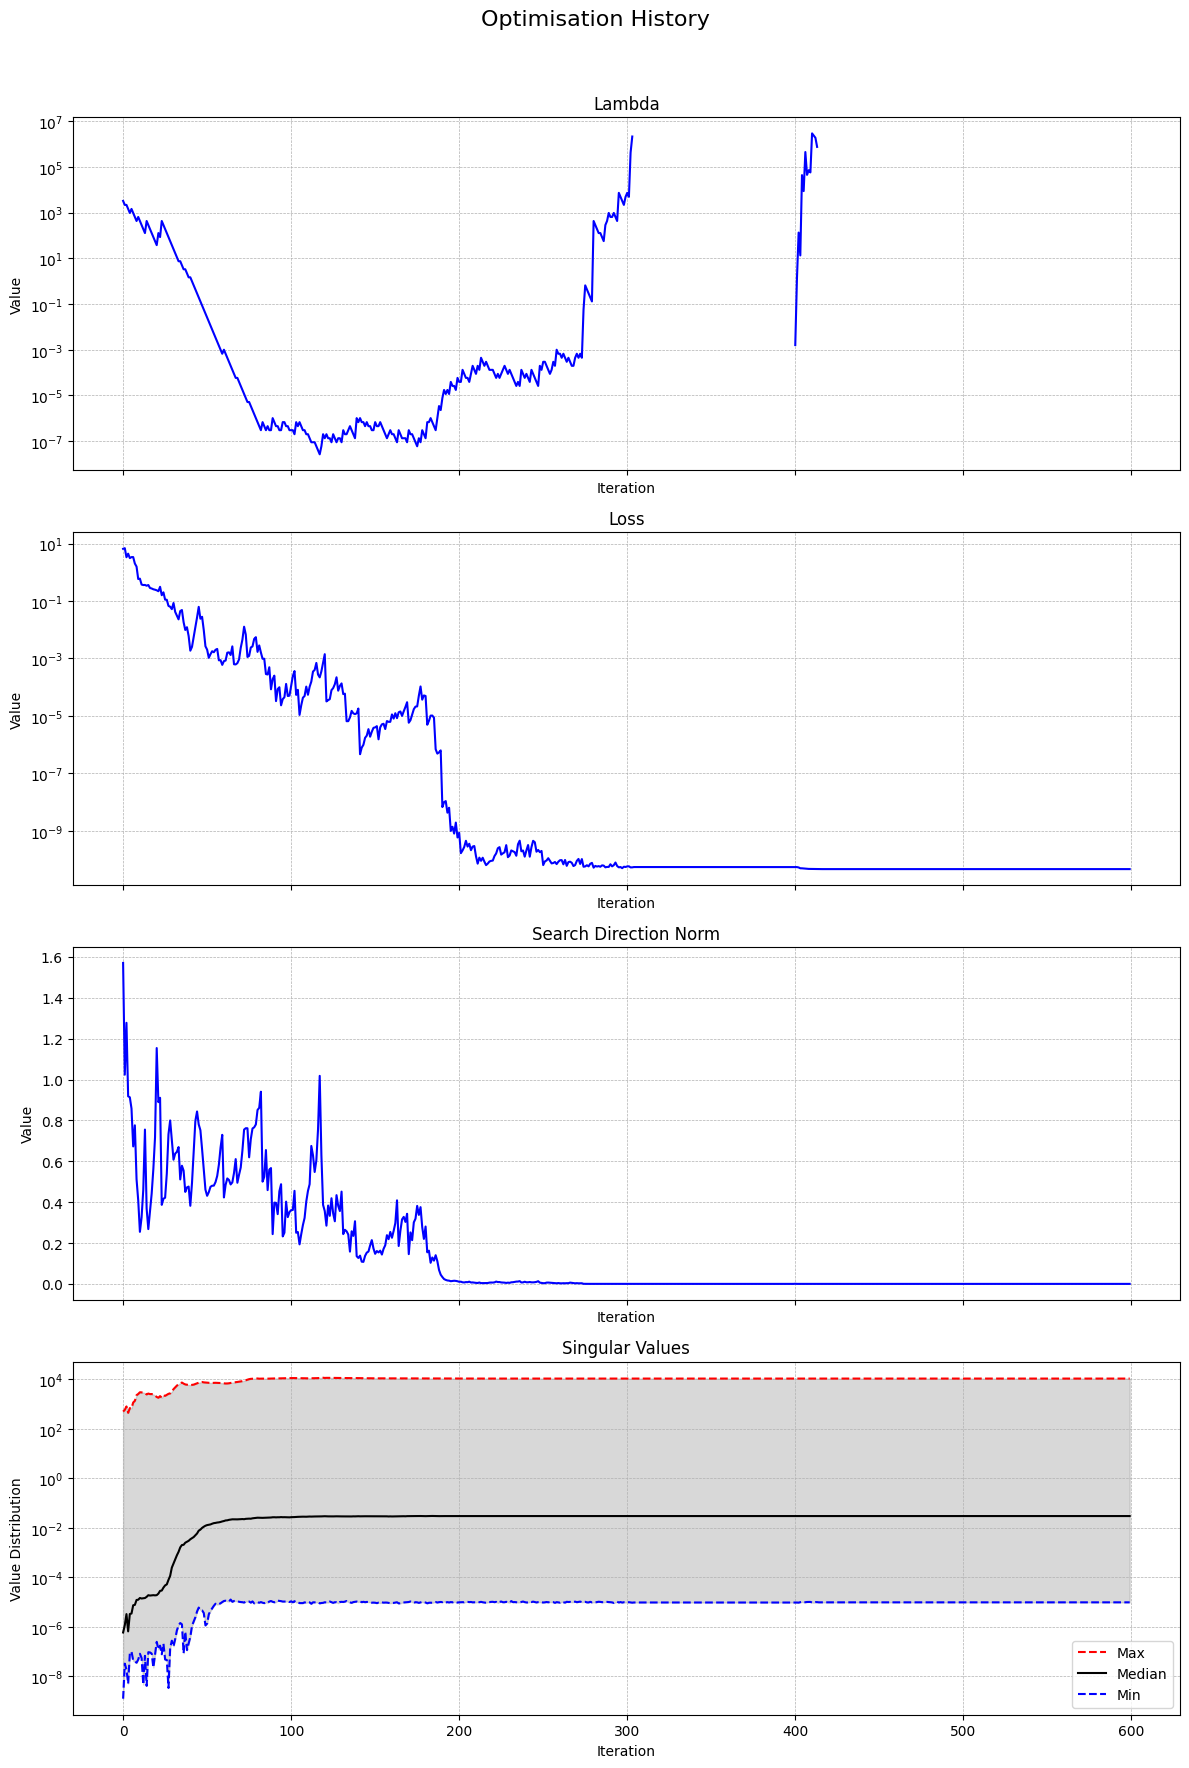

In [8]:
history.plot()